## Red Wine Quality

#### Context
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

#### Content
Input variables (based on physicochemical tests):

1. fixed acidity

2. volatile acidity

3. citric acid

4. residual sugar

5. chlorides

6. free sulfur dioxide

7. total sulfur dioxide

8. density

9. pH

10. sulphates

11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

#### Tips
What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.
Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

1. File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.

2. File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

$quality$ > 6.5 => "good"
TRUE => "bad"

3. Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)

4. Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')

5. Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and

6. Partitioning Node test data split output to input Decision Tree predictor Node

7. Decision Tree learner Node output to input Decision Tree Node input

8. Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)

### Imports Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings('ignore')

## A. Classification Task

### Read Data CSV

In [2]:
df = pd.read_csv('../Datasets/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Exploratory Data Analysis (EDA)

#### Show dimension data, info data & data types

In [3]:
df.shape

(1599, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

#### How many data in quality column

In [6]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

Quality of wine just from 3 - 8

#### Show describe data & correlation data

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


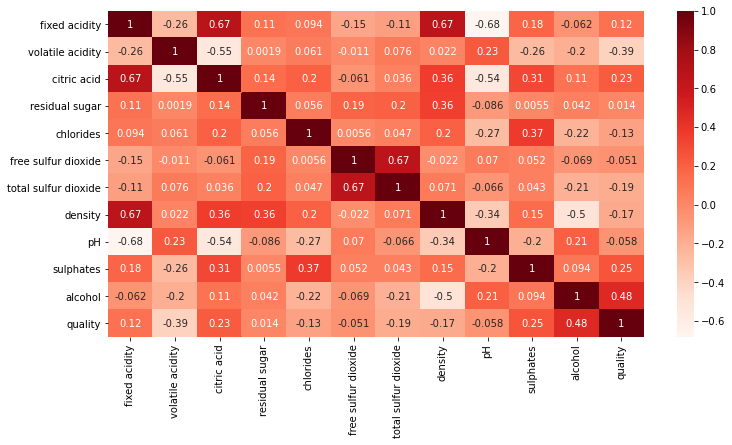

In [9]:
# plot correlation data
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap='Reds', annot=True)
plt.show()

#### Check missing value, duplicate data, & outliers data

In [10]:
# check missing value
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Dataset doesn't have missing value

In [11]:
# check duplicate data
df[df.duplicated()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


Because quality value maybe have data duplicated and quality column is dependent variable, we don't remove it

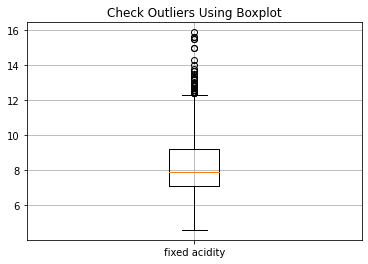

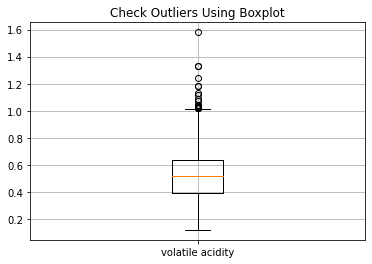

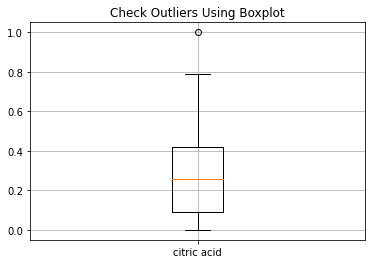

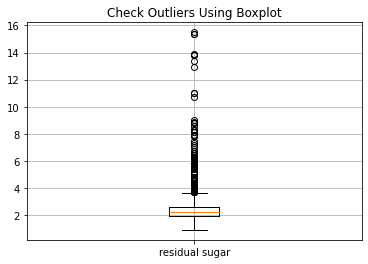

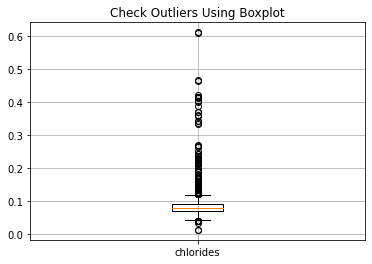

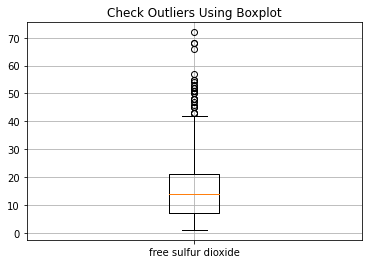

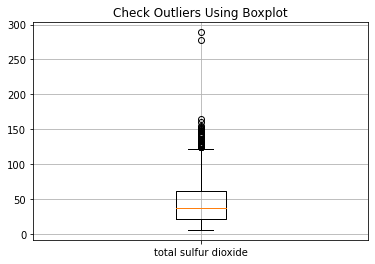

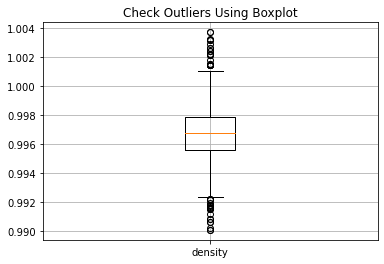

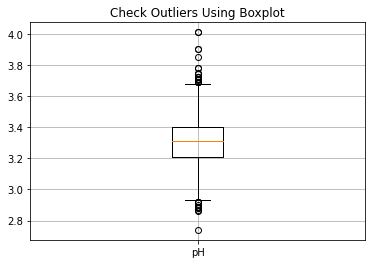

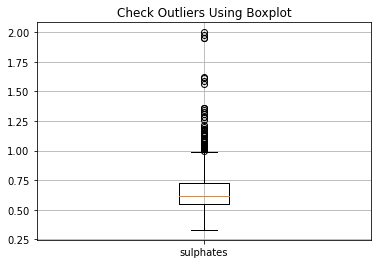

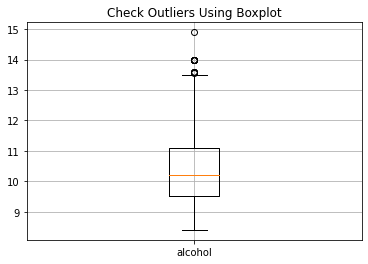

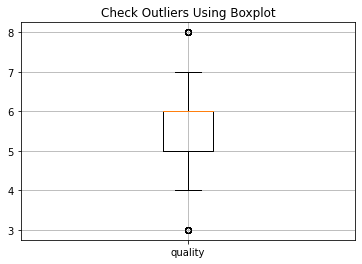

In [12]:
# using boxplot
for box in df.columns:
    plt.boxplot(df[box], labels=[box])
    plt.title('Check Outliers Using Boxplot')
    plt.grid()
    plt.show()

In [13]:
# # check outliers data
# # using IQR & boxplot or scatterplot

# import numpy as np

# for x in df.columns:
#     Q3,Q1 = np.percentile(df.loc[:,x],[75,25])
#     IQR = Q3 - Q1
 
#     max = Q3 + (1.5 * IQR)
#     min = Q1 - (1.5 * IQR)
 
#     df.loc[df[x] < min,x] = np.nan
#     df.loc[df[x] > max,x] = np.nan

# # Q1 = df.quantile(0.25)
# # Q3 = df.quantile(0.75)
# # IQR = Q3 - Q1
# # # IQR
# # low = Q1 - 1.5 * IQR
# # high = Q3 + 1.5 * IQR
# # # df2 = df[(df > low) & (df < high)]
# # df2 = df[~((df < low) | (df > high)).any(axis=1)]

In [14]:
print(df.isnull().sum())
print(f' Jumlah data NaN: {df.isnull().sum().sum()}')

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
 Jumlah data NaN: 0


In [15]:
# df.dropna(axis=0, inplace=True)

In [16]:
# Change data types column quality to int

df['quality'] = df['quality'].astype('int64')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


#### Analys & Visualizations

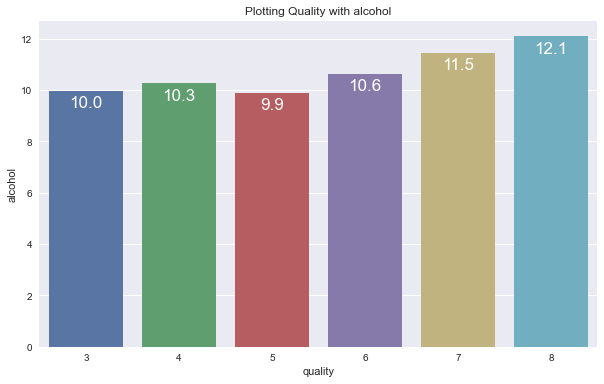

In [17]:
# Make function to plotting with anything input user about dataset df

def plotting(col_y):
    plt.style.use('seaborn')
    plt.subplots(figsize=(10,6))
    bar = sns.barplot(x='quality', y=col_y, data=df, ci=False)
    for i in bar.patches:
        bar.annotate(format(i.get_height(), '.1f'),
                     (i.get_x() + i.get_width() / 2., i.get_height()),
                     ha='center', va='center', color='white', size=17, xytext=(0,-12),
                     textcoords='offset points')
    plt.title(f'Plotting Quality with {col_y}')
    plt.show()

plotting('alcohol')

Quality wine has a high alcohol level so it has high quality is quality 7

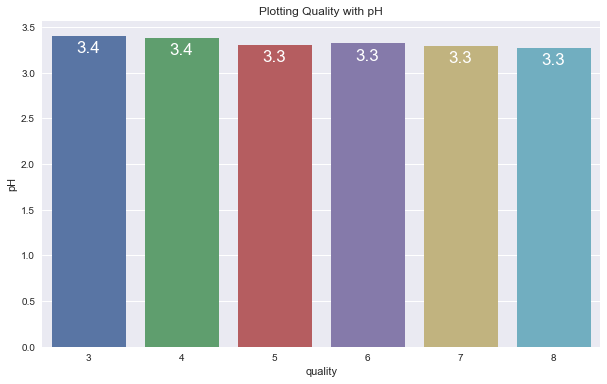

In [18]:
plotting('pH')

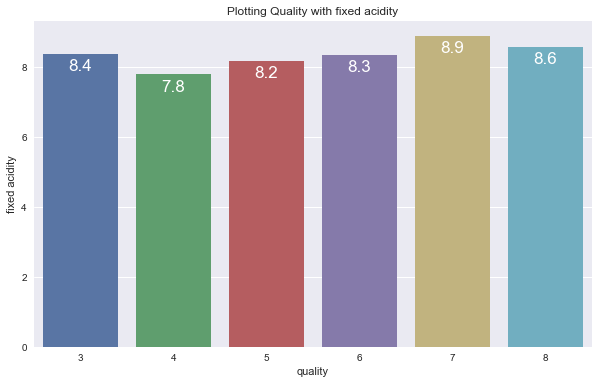

In [19]:
plotting('fixed acidity')

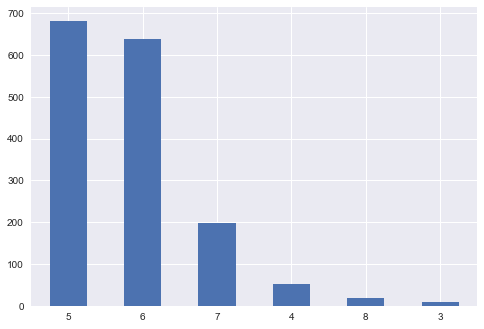

In [20]:
df.quality.value_counts().plot(kind='bar', rot=0);

The output variable likely have imbalanced data

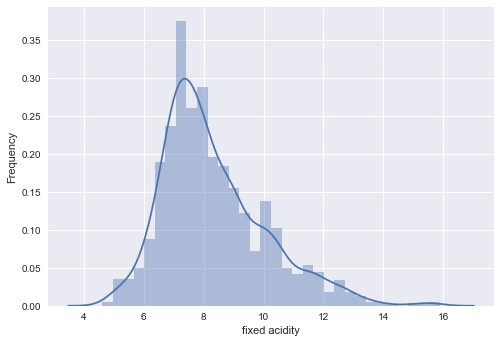

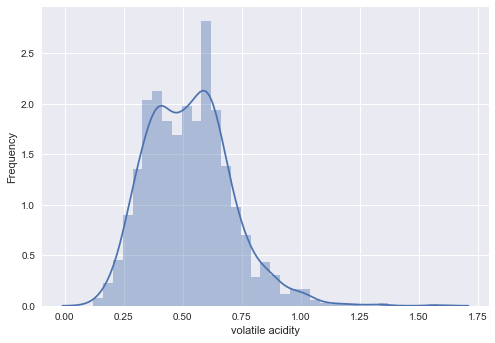

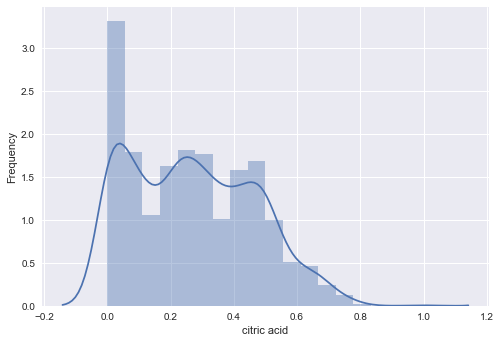

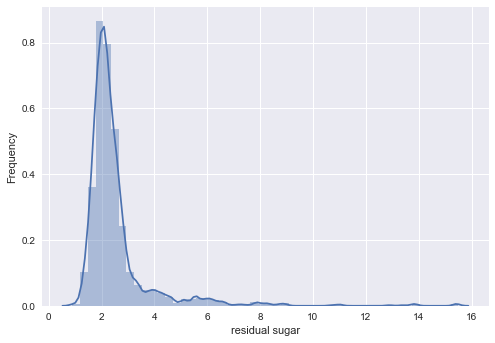

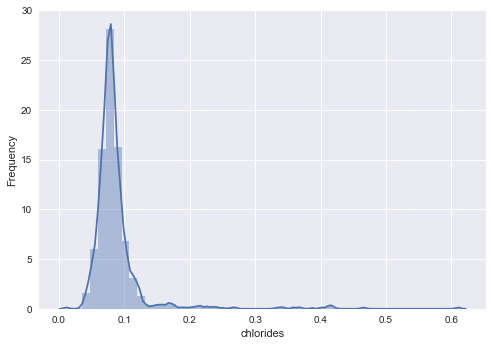

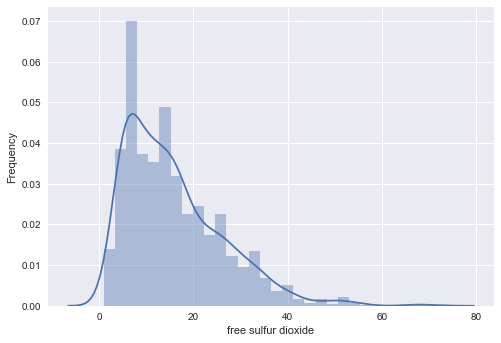

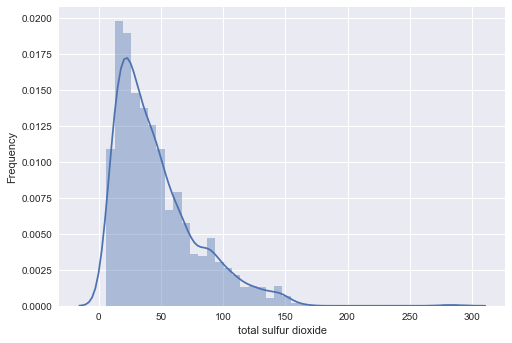

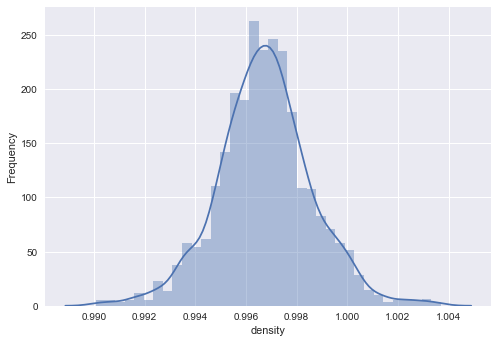

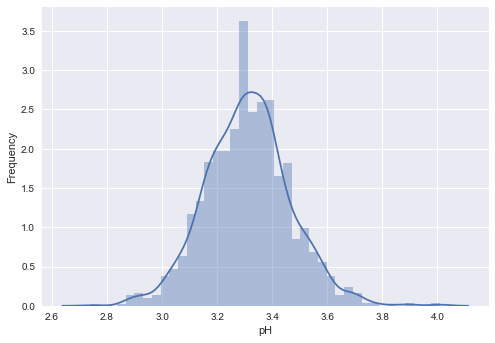

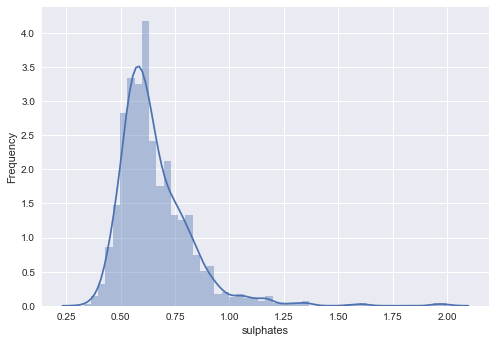

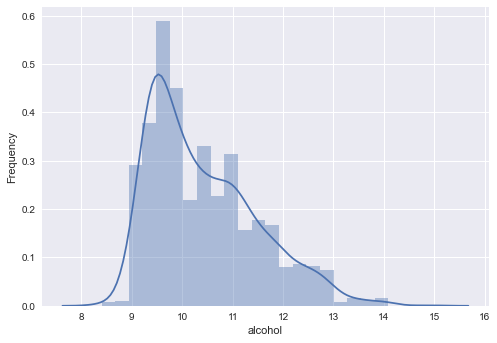

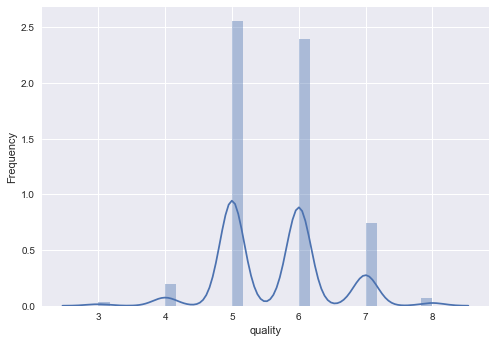

In [21]:
# Plotting data to see distribution for each column
def histPlot(col):
    sns.distplot(df[col])
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for cols in df.columns:
    histPlot(cols)

### Scaling

In [22]:
# split training and testing data for scaler

from sklearn.preprocessing import MinMaxScaler

data = df.copy()

scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(data), columns=[df.columns])
df_scale = scaled.drop('quality', axis=1)
df_scale



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
...,...,...,...,...,...,...,...,...,...,...,...
1594,0.141593,0.328767,0.08,0.075342,0.130217,0.436620,0.134276,0.354626,0.559055,0.149701,0.323077
1595,0.115044,0.294521,0.10,0.089041,0.083472,0.535211,0.159011,0.370778,0.614173,0.257485,0.430769
1596,0.150442,0.267123,0.13,0.095890,0.106845,0.394366,0.120141,0.416300,0.535433,0.251497,0.400000
1597,0.115044,0.359589,0.12,0.075342,0.105175,0.436620,0.134276,0.396476,0.653543,0.227545,0.276923


### Feature Selection & Split Training Testing Data

In [23]:
# split data training & testing for feature selection
X_fs = df_scale
y_fs = df['quality']

# feature selection
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X_fs, y_fs)
scores = pd.DataFrame(fit.scores_)
col = pd.DataFrame(X_fs.columns)
feature_score = pd.concat([col,scores], axis=1)
feature_score.columns = ['Feature','Score']
print(feature_score.nlargest(10, 'Score'))

                    Feature      Score
10               (alcohol,)  36.803074
1       (volatile acidity,)  13.811468
2            (citric acid,)  13.025665
6   (total sulfur dioxide,)  11.180614
9              (sulphates,)   5.474665
7                (density,)   2.525748
5    (free sulfur dioxide,)   2.434120
0          (fixed acidity,)   2.228891
4              (chlorides,)   1.455875
8                     (pH,)   0.706011


0    1382
1     217
Name: quality, dtype: int64


AxesSubplot(0.252969,0.125;0.519062x0.755)


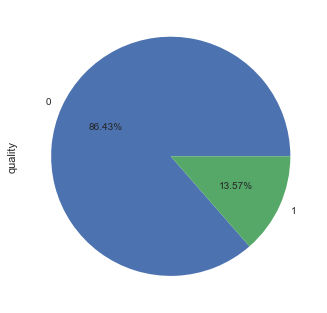

In [24]:
# change target to 0 & 1

y = df['quality'].apply(lambda val: 1 if val >= 7 else 0)
print(y.value_counts())
print('\n')
print(y.value_counts().plot.pie(autopct='%0.2f%%'))

In [25]:
# splitting data training & testing data
X = df_scale[['alcohol','sulphates','total sulfur dioxide','citric acid','volatile acidity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1279, 5) (320, 5) (1279,) (320,)


### Random Oversampling

Because dataset have imbalanced data

In [26]:
from imblearn.over_sampling import RandomOverSampler

0    1382
1    1382
Name: quality, dtype: int64


AxesSubplot(0.252969,0.125;0.519062x0.755)


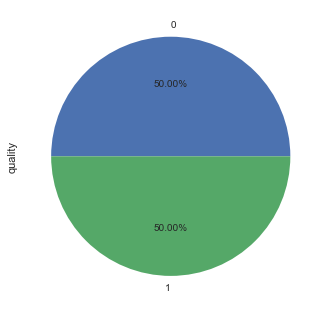

In [27]:
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_train, y_train = ros.fit_resample(X, y)
print(y_train.value_counts())
print('\n')
print(y_train.value_counts().plot.pie(autopct='%0.2f%%'))

### Model Building

1. LogisticRegression
2. RandomForestClassifier
3. KNeighborsClassifier
4. DecisionTreeClassifier
5. SVC
6. GaussianNB

#### Make custom function for model building

In [28]:
def model_building(model):
    models = model
    models.fit(X_train, y_train)
    y_pred = models.predict(X_test)
    print(f'Accuracy Score DecisonTreeClassifer: {accuracy_score(y_test, y_pred)}', '\n')
    print(f'Classification Report DecisonTreeClassifer: \n{classification_report(y_test, y_pred)}', '\n')
    print(f'Confusion Matrix DecisonTreeClassifer: \n{confusion_matrix(y_test, y_pred)}', '\n')
    print(f'Cross Val Score {cross_val_score(models, X, y, cv=5).mean()}')
    print('\n')
    prob_estimates = model.predict_proba(X_test)
    
    fpr, tpr, threshold = roc_curve(y_test, prob_estimates[:, 1])
    nilai_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC: {nilai_auc}')
    plt.plot([0,1], [0,1], 'r--', label='Random Classifier')
    plt.title('ROC: Receiver Operating Charateristic')
    plt.ylabel('Recall or True Positive Rate')
    plt.xlabel('Fallout or False Positive Rate')
    plt.legend()
    plt.show()
    
    

#### 1. LogisticRegression

Accuracy Score DecisonTreeClassifer: 0.725 

Classification Report DecisonTreeClassifer: 
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       290
           1       0.23      0.83      0.36        30

    accuracy                           0.73       320
   macro avg       0.60      0.77      0.59       320
weighted avg       0.91      0.72      0.78       320
 

Confusion Matrix DecisonTreeClassifer: 
[[207  83]
 [  5  25]] 

Cross Val Score 0.8674177115987461




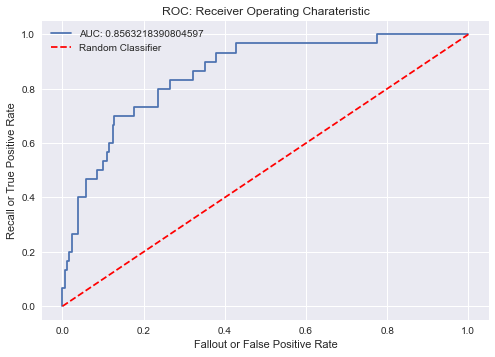

In [29]:
model_building(LogisticRegression())

#### 2. RandomForestClassifier

Accuracy Score DecisonTreeClassifer: 1.0 

Classification Report DecisonTreeClassifer: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00        30

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320
 

Confusion Matrix DecisonTreeClassifer: 
[[290   0]
 [  0  30]] 

Cross Val Score 0.8717848746081505




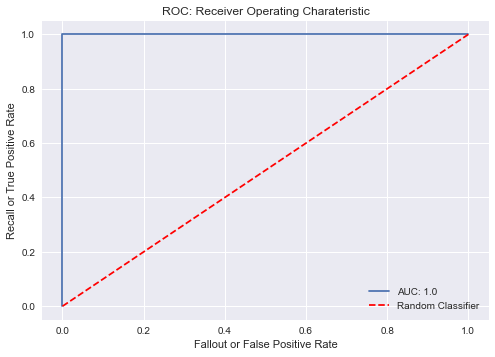

In [30]:
model_building(RandomForestClassifier(n_estimators=100))

#### 3. KNeighborsClassifier

Accuracy Score DecisonTreeClassifer: 0.8625 

Classification Report DecisonTreeClassifer: 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       290
           1       0.41      1.00      0.58        30

    accuracy                           0.86       320
   macro avg       0.70      0.92      0.75       320
weighted avg       0.94      0.86      0.89       320
 

Confusion Matrix DecisonTreeClassifer: 
[[246  44]
 [  0  30]] 

Cross Val Score 0.8586618338557994




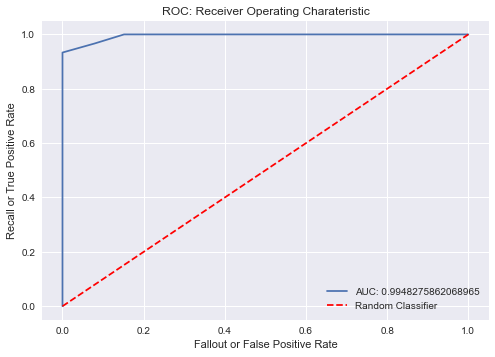

In [31]:
model_building(KNeighborsClassifier(n_neighbors=5))

#### 4. DecisionTreeClassifier

Accuracy Score DecisonTreeClassifer: 1.0 

Classification Report DecisonTreeClassifer: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00        30

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320
 

Confusion Matrix DecisonTreeClassifer: 
[[290   0]
 [  0  30]] 

Cross Val Score 0.8173844043887147




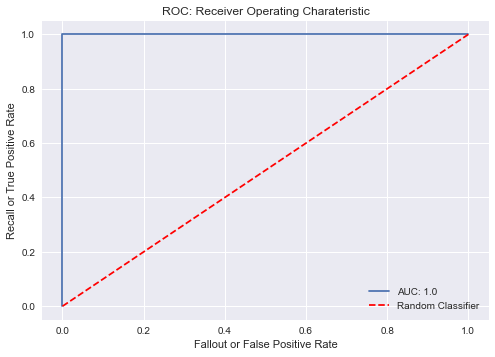

In [32]:
model_building(DecisionTreeClassifier())

#### 5. SVC

Accuracy Score DecisonTreeClassifer: 0.740625 

Classification Report DecisonTreeClassifer: 
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       290
           1       0.25      0.87      0.39        30

    accuracy                           0.74       320
   macro avg       0.61      0.80      0.61       320
weighted avg       0.91      0.74      0.79       320
 

Confusion Matrix DecisonTreeClassifer: 
[[211  79]
 [  4  26]] 

Cross Val Score 0.8768005485893416




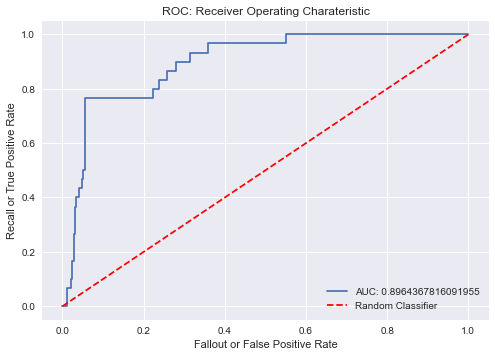

In [33]:
model_building(SVC(probability=True))

#### 6. GaussianNB

Accuracy Score DecisonTreeClassifer: 0.70625 

Classification Report DecisonTreeClassifer: 
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       290
           1       0.22      0.83      0.35        30

    accuracy                           0.71       320
   macro avg       0.60      0.76      0.58       320
weighted avg       0.90      0.71      0.77       320
 

Confusion Matrix DecisonTreeClassifer: 
[[201  89]
 [  5  25]] 

Cross Val Score 0.8555446708463951




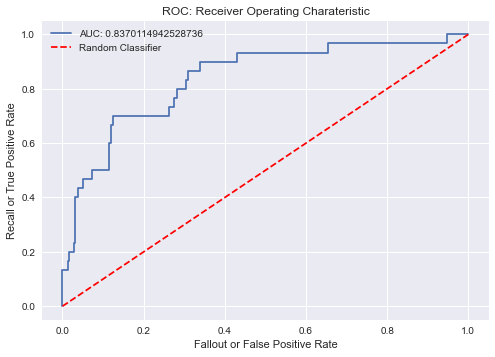

In [34]:
model_building(GaussianNB())

### Make plotting to see the best performance of the model

In [35]:
# get the accuracy score & cross val score first

mod_name = [LogisticRegression(), RandomForestClassifier(n_estimators=100), KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), 
            SVC(), GaussianNB()]
acc_mod = []
cv_mod = []

for mod in mod_name:
    models = mod
    models.fit(X_train, y_train)
    y_pred = models.predict(X_test)
    acc_mod.append(accuracy_score(y_test, y_pred))
    cv_mod.append(cross_val_score(models, X, y, cv=5).mean())

print(f'Accuracy Model: {acc_mod}', '\n')
print(f'Cross Val Score Model: {cv_mod}', '\n')

Accuracy Model: [0.725, 1.0, 0.8625, 1.0, 0.740625, 0.70625] 

Cross Val Score Model: [0.8674177115987461, 0.8755427115987461, 0.8586618338557994, 0.8105074451410659, 0.8768005485893416, 0.8555446708463951] 



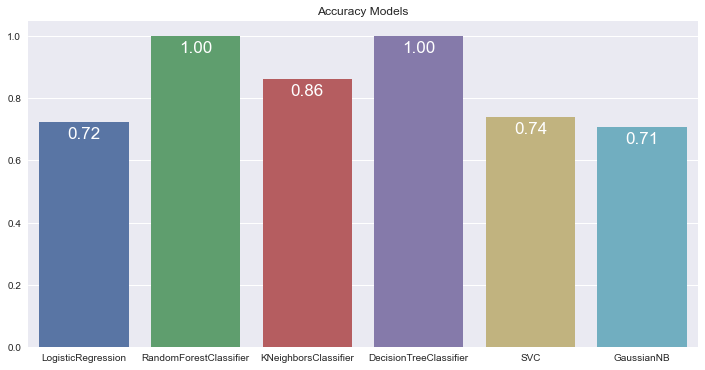

In [36]:
# plotting performance model
models_names = ['LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 
                'SVC', 'GaussianNB']


plt.style.use('seaborn')
plt.subplots(figsize=(12,6))
bar = sns.barplot(x=models_names, y=acc_mod, ci=False)
for i in bar.patches:
    bar.annotate(format(i.get_height(), '.2f'),
                 (i.get_x() + i.get_width() / 2., i.get_height()),
                 ha='center', va='center', color='white', size=17, xytext=(0,-12),
                 textcoords='offset points')
plt.title(f'Accuracy Models')
plt.show()

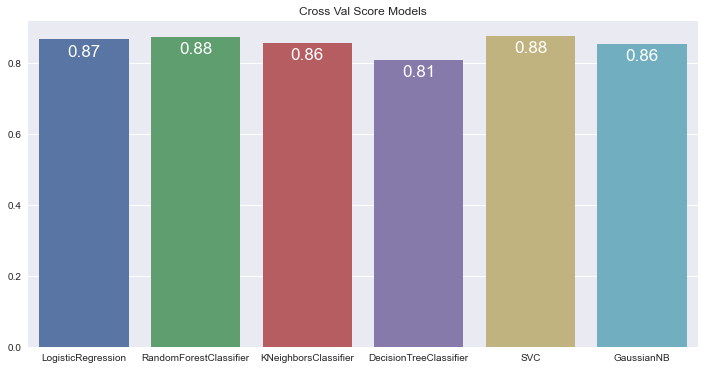

In [37]:
plt.style.use('seaborn')
plt.subplots(figsize=(12,6))
bar = sns.barplot(x=models_names, y=cv_mod, ci=False)
for i in bar.patches:
    bar.annotate(format(i.get_height(), '.2f'),
                 (i.get_x() + i.get_width() / 2., i.get_height()),
                 ha='center', va='center', color='white', size=17, xytext=(0,-12),
                 textcoords='offset points')
plt.title(f'Cross Val Score Models')
plt.show()

### Get best parameters for model using RandomizedSearchCV

In [47]:
model_params = {
    "RandomForestClassifier" : {
        "model" : RandomForestClassifier(),
        "params" : {
            "n_estimators" : [60,80,100],
            "bootstrap" : [True],
            "max_depth" : [60,80,100,120],
            "min_samples_leaf" : [2,3,5,7],
            "min_samples_split" : [10,12,14],
            "max_features" : [2,3,4,5]
        }
    },
    
    "KNeighborsClassifier" : {
        "model" : KNeighborsClassifier(),
        "params" : {
            "n_neighbors" : [2,3,4,5,6],
            "leaf_size" : [50,60,70,80],
            "n_jobs" : [-1,1]
        }
    },
    
    "DecisionTreeClassifier" : {
        "model" : DecisionTreeClassifier(),
        "params" : {
            "criterion" : ['gini','entropy'],
            "max_depth" : [60,70,80,90],
            "min_samples_leaf" : [7,8,9],
            "min_samples_split" : [10,11,12]
        }
    },
    
    "LogisticRegression" : {
        "model" : LogisticRegression(solver='liblinear', multi_class='auto'),
        "params" : {
            "C" : [1,5,10]
        }
    },
    
    "SVC" : {
        "model" : SVC(),
        "params" : {
            "C" : [1.0, 1.5, 2.0],
            "kernel" : ['linear', 'rbf'],
            "gamma" : ['scale', 'auto']
        }
    },
    
    "GaussianNB" : {
        "model" : GaussianNB(),
        "params" : {
            "priors" : [None],
            "var_smoothing" : [1e-09]
        }
    }
}

In [51]:
# scores = []

for model_name, model_par in model_params.items():
    res = RandomizedSearchCV(model_par['model'], model_par['params'], cv=5, n_iter=3, return_train_score=False)
    res.fit(X_train, y_train)
    print(f'Model {model_name}, Best Scores: {res.best_score_}')
#     scores.append({
#         'model' : model_name,
#         'best_score' : res.best_score_
#     })

Model RandomForestClassifier, Best Scores: 0.9345126713316037
Model KNeighborsClassifier, Best Scores: 0.9044821395812039
Model DecisionTreeClassifier, Best Scores: 0.8849542678931783
Model LogisticRegression, Best Scores: 0.7782274549885997
Model SVC, Best Scores: 0.8035445658725789
Model GaussianNB, Best Scores: 0.7728077416987709


In [54]:
for model_name, model_par in model_params.items():
    res = RandomizedSearchCV(model_par['model'], model_par['params'], cv=5, n_iter=3, return_train_score=False)
    res.fit(X_train, y_train)
    print(f'Model {model_name}, Best Params: {res.best_params_}\n')

Model RandomForestClassifier, Best Params: {'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 4, 'max_depth': 120, 'bootstrap': True}

Model KNeighborsClassifier, Best Params: {'n_neighbors': 3, 'n_jobs': 1, 'leaf_size': 60}

Model DecisionTreeClassifier, Best Params: {'min_samples_split': 10, 'min_samples_leaf': 7, 'max_depth': 90, 'criterion': 'gini'}

Model LogisticRegression, Best Params: {'C': 1}

Model SVC, Best Params: {'kernel': 'linear', 'gamma': 'scale', 'C': 1.0}

Model GaussianNB, Best Params: {'var_smoothing': 1e-09, 'priors': None}



### Predict new data with `DecisionTreeClassifier`

In [72]:
# DecisionTreeClassifier
mod_tree = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=7, max_depth=90, criterion='gini')
mod_tree.fit(X_train, y_train)
y_pred_tree = mod_tree.predict(X_test)
print(f'Accuracy Score DecisonTreeClassifer: {accuracy_score(y_test, y_pred_tree)}', '\n')
print(f'Classification Report DecisonTreeClassifer: \n{classification_report(y_test, y_pred_tree)}', '\n')
print(f'Confusion Matrix DecisonTreeClassifer: \n{confusion_matrix(y_test, y_pred_tree)}', '\n')
print(f'Cross Val Score {cross_val_score(mod_tree, X, y, cv=5).mean()}')

Accuracy Score DecisonTreeClassifer: 0.9375 

Classification Report DecisonTreeClassifer: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       290
           1       0.60      1.00      0.75        30

    accuracy                           0.94       320
   macro avg       0.80      0.97      0.86       320
weighted avg       0.96      0.94      0.94       320
 

Confusion Matrix DecisonTreeClassifer: 
[[270  20]
 [  0  30]] 

Cross Val Score 0.8436442006269592


We use model DecisonTreeClassifer because have roc curve 1 and RandomForestClassifier might be can be use to 

In [73]:
# predict new data DecisonTreeClassifer
y_pred_tree = mod_tree.predict(X_test+120)
print(f'Confusion Matrix DecisonTreeClassifer: \n{confusion_matrix(y_test, y_pred_tree)}', '\n')

Confusion Matrix DecisonTreeClassifer: 
[[290   0]
 [ 30   0]] 



In [81]:
X_test[:5]

,alcohol,sulphates,total sulfur dioxide,citric acid,volatile acidity
1109,0.369231,0.257485,0.212014,0.43,0.239726
1032,0.184615,0.119760,0.028269,0.00,0.479452
1002,0.507692,0.305389,0.074205,0.33,0.116438
487,0.246154,0.053892,0.028269,0.36,0.359589
979,0.307692,0.179641,0.000000,0.49,0.226027


In [91]:
pred = [0.276804*2, 0.099892, 0.045869, 0.42, 0.359798]
mod_tree.predict([pred])

array([1], dtype=int64)

So, with model DecisionTreeClassifier we can use for predict quality of red wine quality. If you want to use another model, its possible because all model have a good performance. But, iam want to use DecisionTreeClassifier to predict red wine quality.